# **Navid Ebeahimi 99521001**

In [1]:
!pip install transformers
!pip install wget
!pip install accelerate -U
!pip install datasets
!pip install -q clean-text[gpl]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c012257ebd86ffff4e28ee64de72f16f3f470a05a121cb043a19e8d8d4962696
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
from torch.utils.data import DataLoader
from transformers import AutoModel, BertTokenizerFast
import zipfile
import wget

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Download Dataset**

In [4]:
url = 'https://drive.usercontent.google.com/u/0/uc?id=1YgrCYY-Z0h2z0-PfWVfOGt1Tv0JDI-qz&export=download'
wget.download(url)

'digimag.zip'

In [5]:
zip_file_path = '/content/digimag.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset/')

## Train Data

In [6]:
df_train = pd.read_csv("/content/Dataset/digimag/train.csv", delimiter='\t')
df_train.head()

,Unnamed: 0,content,label,label_id
0,0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,3
1,1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,5
2,2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,5
3,3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,3
4,4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0


## Dev Data

In [7]:
df_dev = pd.read_csv("/content/Dataset/digimag/dev.csv", delimiter='\t')
df_dev.head()

,Unnamed: 0,content,label,label_id
0,0,نت‌فلیکس مجموعه‌ی سریالی کسلوانیا را می‌سازد [...,هنر و سینما,5
1,1,کارگردان The Last Guardian از بازی بعدی‌اش می‌...,بازی ویدیویی,0
2,2,کارت اعتباری اپل کارت معرفی شد در مراسم Show T...,علم و تکنولوژی,3
3,3,از کنفرانس مایکروسافت و کنسول بعدی سونی تا دیگ...,بازی ویدیویی,0
4,4,از رویداد ماه اکتبر اپل چه انتظاراتی داریم؟ در...,علم و تکنولوژی,3


## Test Data

In [8]:
df_test = pd.read_csv("/content/Dataset/digimag/test.csv", delimiter='\t')
df_test.head()

,Unnamed: 0,content,label,label_id
0,0,با این ۵ صبحانه رژیمی لاغر شوید صبحانه همیشه ب...,سلامت و زیبایی,2
1,1,نمایشگر گوشی تاشونده ال‌جی مانند بروشور باز و ...,علم و تکنولوژی,3
2,2,چرا برخی سلبریتی‌های هالیوودی از شبکه‌های اجتم...,هنر و سینما,5
3,3,گوگل استیدیا؛ آینده‌ی صنعت بازی یا محکوم به شک...,بازی ویدیویی,0
4,4,ویژگی جذاب گلکسی Z Flip به زودی به گوشی‌های ان...,علم و تکنولوژی,3


# **Preprocessing Data**

In [9]:
import re
from cleantext import clean

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # normalizing
    arabic_chars = ['ي', 'ك']
    farsi_chars = ['ی', 'ک']
    for arabic, farsi in zip(arabic_chars, farsi_chars):
        text = text.replace(arabic, farsi)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

In [10]:
df_train['content'] = df_train['content'].apply(cleaning)
df_dev['content'] = df_dev['content'].apply(cleaning)
df_test['content'] = df_test['content'].apply(cleaning)

# **Analyze Data**

## Train

label
علم و تکنولوژی    2245
بازی ویدیویی      1593
هنر و سینما       1350
سلامت و زیبایی    1304
کتاب و ادبیات      206
راهنمای خرید       101
عمومی               97
Name: count, dtype: int64


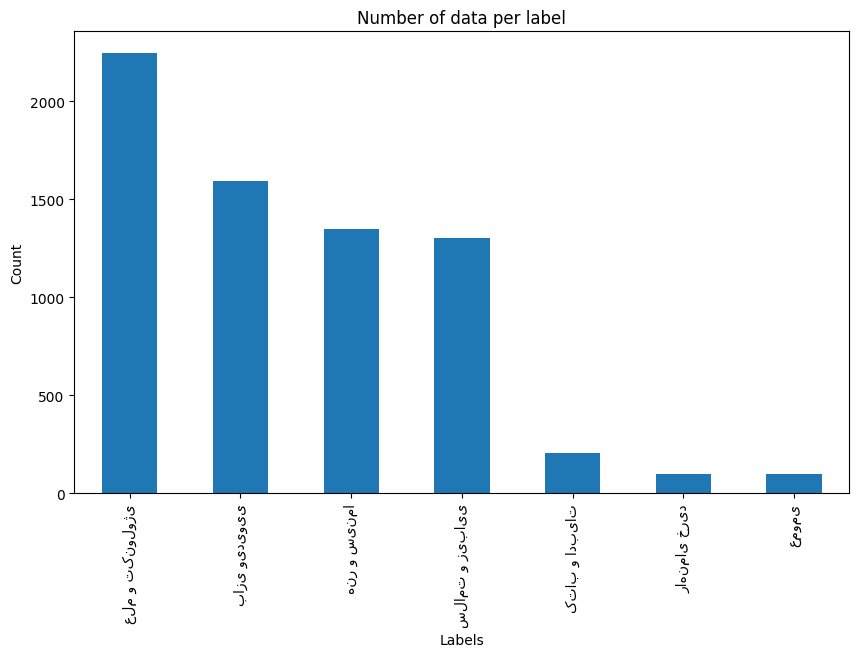

In [11]:
# Compute the number of data that belongs to each label
label_counts = df_train['label'].value_counts()

# Print the counts
print(label_counts)

# Plot the counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Number of data per label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [12]:
# Assuming df is your DataFrame and 'label' and 'label_id' are the columns you want to change
labels_to_aggregate = ['کتاب و ادبیات', 'راهنمای خرید', 'عمومی']  # replace these with your actual labels

df_train.loc[df_train['label'].isin(labels_to_aggregate), 'label'] = 'others'
df_train.loc[df_train['label_id']==5, 'label_id'] = 1
df_train.loc[df_train['label'] == 'others', 'label_id'] = 4

label
علم و تکنولوژی    2245
بازی ویدیویی      1593
هنر و سینما       1350
سلامت و زیبایی    1304
others             404
Name: count, dtype: int64


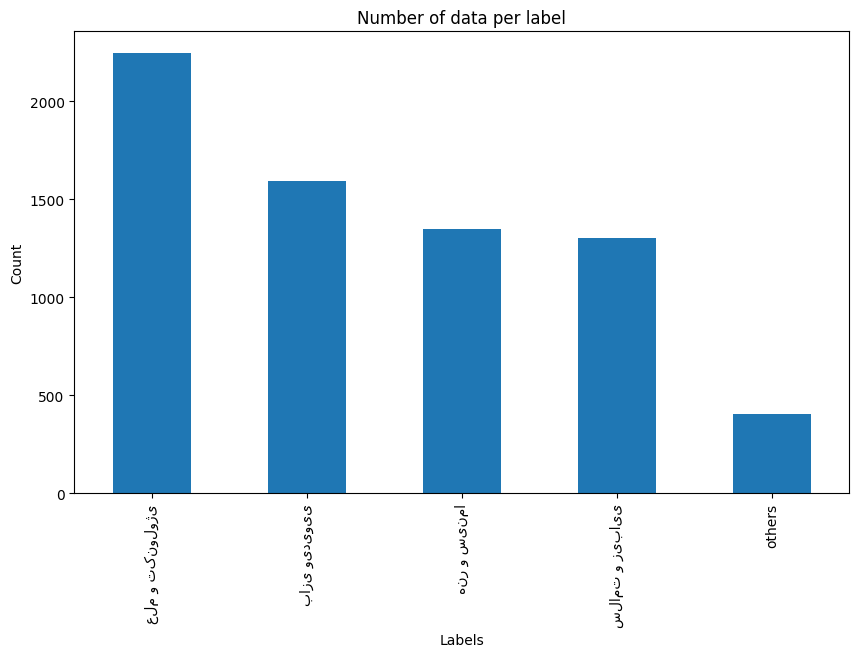

In [13]:
# Compute the number of data that belongs to each label
label_counts = df_train['label'].value_counts()

# Print the counts
print(label_counts)

# Plot the counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Number of data per label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## Dev

label
علم و تکنولوژی    250
بازی ویدیویی      177
هنر و سینما       150
سلامت و زیبایی    145
کتاب و ادبیات      23
عمومی              11
راهنمای خرید       11
Name: count, dtype: int64


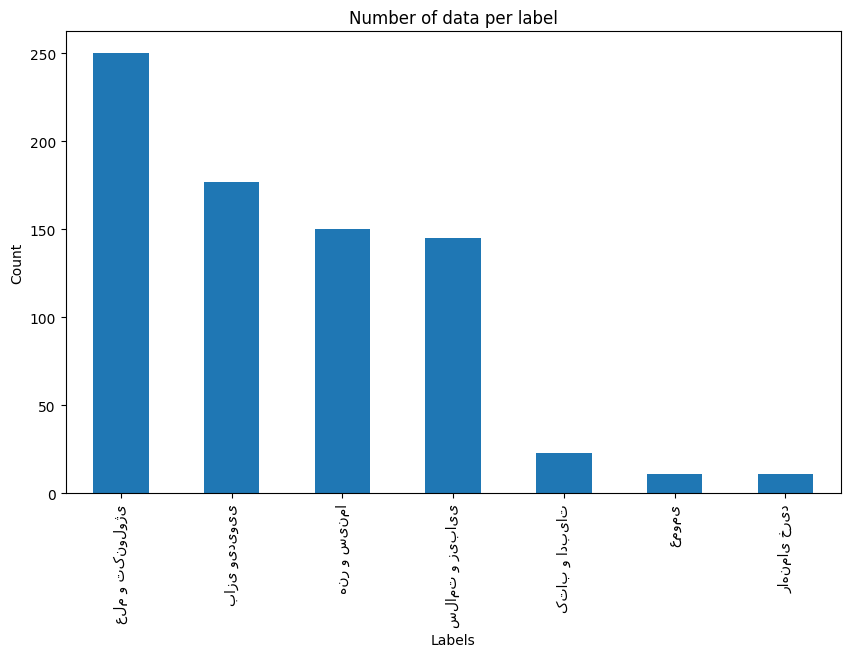

In [14]:
# Compute the number of data that belongs to each label
label_counts = df_dev['label'].value_counts()

# Print the counts
print(label_counts)

# Plot the counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Number of data per label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [15]:
# Assuming df is your DataFrame and 'label' and 'label_id' are the columns you want to change
labels_to_aggregate = ['کتاب و ادبیات', 'راهنمای خرید', 'عمومی']  # replace these with your actual labels

df_dev.loc[df_dev['label'].isin(labels_to_aggregate), 'label'] = 'others'
df_dev.loc[df_dev['label_id']==5, 'label_id'] = 1
df_dev.loc[df_dev['label'] == 'others', 'label_id'] = 4

label
علم و تکنولوژی    250
بازی ویدیویی      177
هنر و سینما       150
سلامت و زیبایی    145
others             45
Name: count, dtype: int64


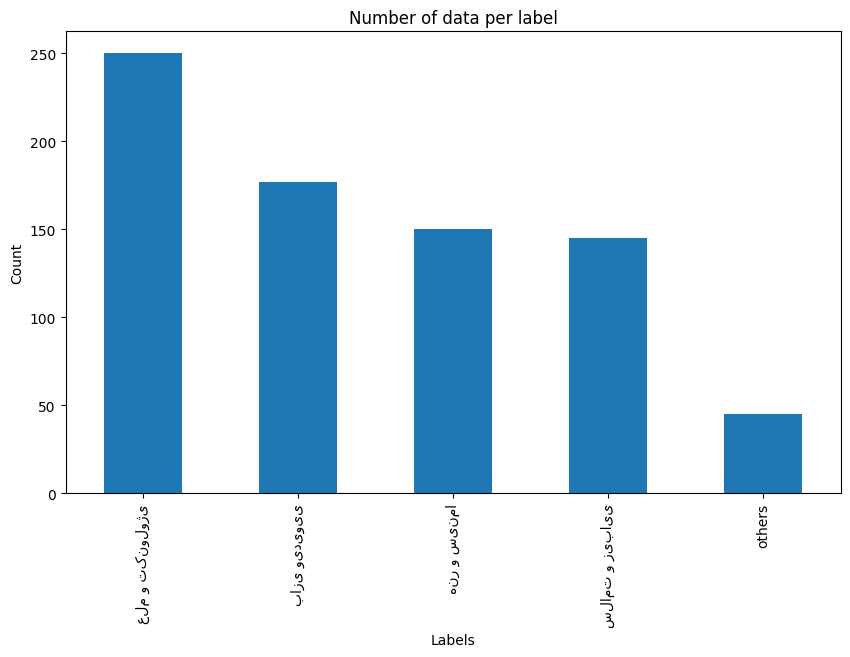

In [16]:
# Compute the number of data that belongs to each label
label_counts = df_dev['label'].value_counts()

# Print the counts
print(label_counts)

# Plot the counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Number of data per label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## Test

label
علم و تکنولوژی    277
بازی ویدیویی      197
هنر و سینما       167
سلامت و زیبایی    161
کتاب و ادبیات      25
راهنمای خرید       13
عمومی              12
Name: count, dtype: int64


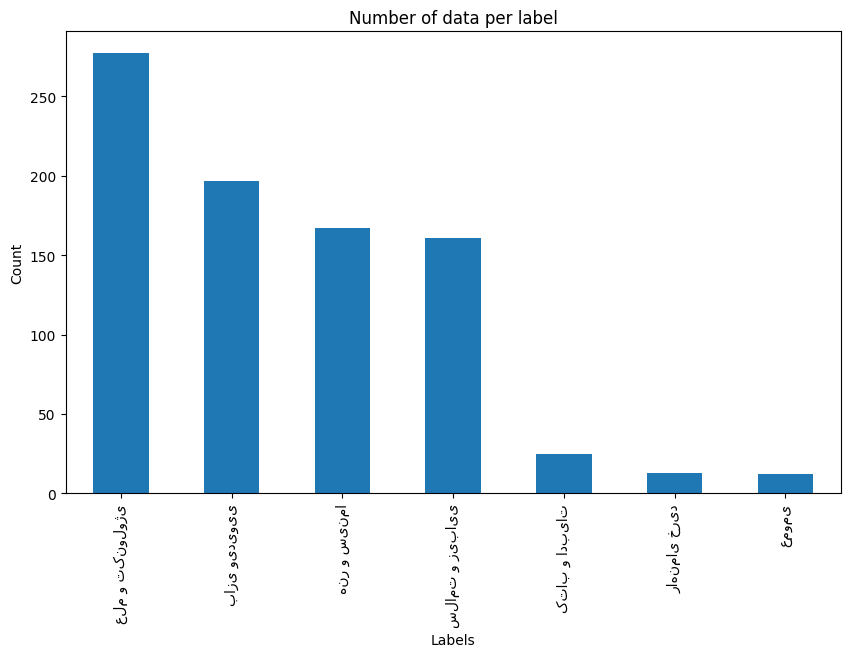

In [17]:
# Compute the number of data that belongs to each label
label_counts = df_test['label'].value_counts()

# Print the counts
print(label_counts)

# Plot the counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Number of data per label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [18]:
# Assuming df is your DataFrame and 'label' and 'label_id' are the columns you want to change
labels_to_aggregate = ['کتاب و ادبیات', 'راهنمای خرید', 'عمومی']  # replace these with your actual labels

df_test.loc[df_test['label'].isin(labels_to_aggregate), 'label'] = 'others'
df_test.loc[df_test['label_id']==5, 'label_id'] = 1
df_test.loc[df_test['label'] == 'others', 'label_id'] = 4

label
علم و تکنولوژی    277
بازی ویدیویی      197
هنر و سینما       167
سلامت و زیبایی    161
others             50
Name: count, dtype: int64


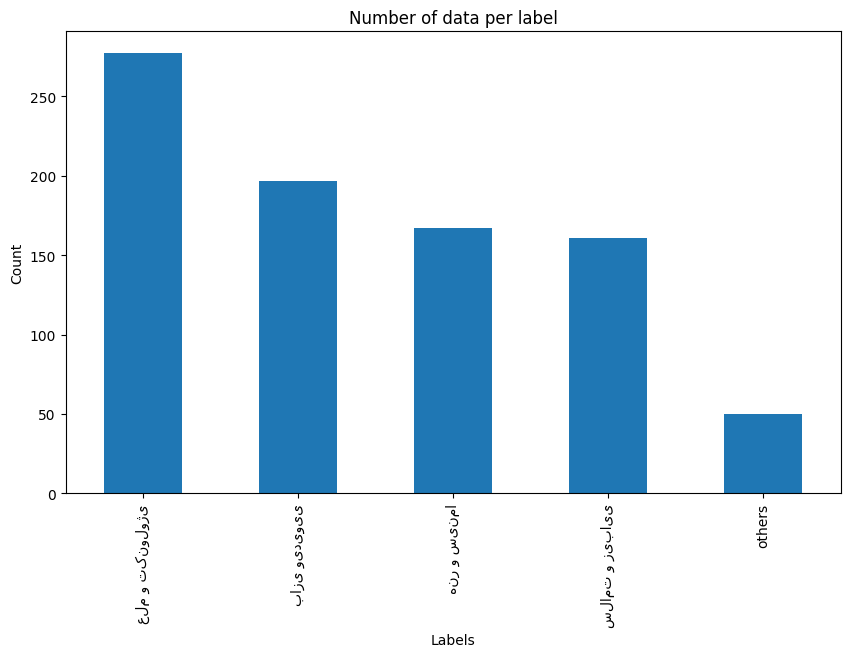

In [19]:
# Compute the number of data that belongs to each label
label_counts = df_test['label'].value_counts()

# Print the counts
print(label_counts)

# Plot the counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Number of data per label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# **Model**

In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('ViraIntelligentDataMining/AriaBERT')
model = AutoModelForSequenceClassification.from_pretrained('ViraIntelligentDataMining/AriaBERT', num_labels=5)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ViraIntelligentDataMining/AriaBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Preparing Dataset**

In [21]:
from datasets import Dataset

ds_train = Dataset.from_pandas(df_train)
ds_dev = Dataset.from_pandas(df_dev)
ds_test = Dataset.from_pandas(df_test)

In [22]:
def tokenize(tok):
  return tokenizer(tok['content'], truncation=True, padding=True)

In [23]:
def make_inputs(dataset):
  inputs = dataset.map(tokenize, batched=True, batch_size=16)
  inputs = inputs.remove_columns(['label','Unnamed: 0', 'content'])
  inputs = inputs.rename_column('label_id', 'labels')

  inputs.set_format("torch")
  return inputs

In [24]:
ds_train = make_inputs(ds_train)
ds_dev = make_inputs(ds_dev)
ds_test = make_inputs(ds_test)

Map:   0%|          | 0/6896 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/852 [00:00<?, ? examples/s]

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    acc = accuracy_score(labels, predictions)

    # Prepare output dictionary
    output = {'accuracy': acc}
    for i in range(5):  # Assuming 5 labels
        output.update({
            f'precision_{i}': precision[i],
            f'recall_{i}': recall[i],
            f'f1_{i}': f1[i]
        })

    return output


## **Training Model**

In [33]:
# Define your training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    seed=224,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_dev,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision 0,Recall 0,F1 0,Precision 1,Recall 1,F1 1,Precision 2,Recall 2,F1 2,Precision 3,Recall 3,F1 3,Precision 4,Recall 4,F1 4
1,0.300800,0.238777,0.941330,0.971591,0.966102,0.968839,0.901235,0.973333,0.935897,0.925170,0.937931,0.931507,0.968504,0.984000,0.976190,0.821429,0.511111,0.630137
2,0.103000,0.229240,0.950456,0.966480,0.977401,0.971910,0.924051,0.973333,0.948052,0.951049,0.937931,0.944444,0.987805,0.972000,0.979839,0.756098,0.688889,0.720930


Epoch,Training Loss,Validation Loss,Accuracy,Precision 0,Recall 0,F1 0,Precision 1,Recall 1,F1 1,Precision 2,Recall 2,F1 2,Precision 3,Recall 3,F1 3,Precision 4,Recall 4,F1 4
1,0.300800,0.238777,0.941330,0.971591,0.966102,0.968839,0.901235,0.973333,0.935897,0.925170,0.937931,0.931507,0.968504,0.984000,0.976190,0.821429,0.511111,0.630137
2,0.103000,0.229240,0.950456,0.966480,0.977401,0.971910,0.924051,0.973333,0.948052,0.951049,0.937931,0.944444,0.987805,0.972000,0.979839,0.756098,0.688889,0.720930
3,0.021900,0.215812,0.956975,0.988571,0.977401,0.982955,0.930818,0.986667,0.957929,0.964286,0.931034,0.947368,0.968627,0.988000,0.978218,0.815789,0.688889,0.746988


TrainOutput(global_step=2586, training_loss=0.20547354395363743, metrics={'train_runtime': 2361.943, 'train_samples_per_second': 8.759, 'train_steps_per_second': 1.095, 'total_flos': 5443388131295232.0, 'train_loss': 0.20547354395363743, 'epoch': 3.0})

## **Evaluate Model**

In [34]:
# Evaluate the model
eval_results = trainer.evaluate(eval_dataset=ds_test)

In [35]:
eval_results

{'eval_loss': 0.25283801555633545,
 'eval_accuracy': 0.9518779342723005,
 'eval_precision_0': 0.9795918367346939,
 'eval_recall_0': 0.9746192893401016,
 'eval_f1_0': 0.9770992366412214,
 'eval_precision_1': 0.9421965317919075,
 'eval_recall_1': 0.9760479041916168,
 'eval_f1_1': 0.9588235294117647,
 'eval_precision_2': 0.9430379746835443,
 'eval_recall_2': 0.9254658385093167,
 'eval_f1_2': 0.9341692789968652,
 'eval_precision_3': 0.9781021897810219,
 'eval_recall_3': 0.9675090252707581,
 'eval_f1_3': 0.9727767695099819,
 'eval_precision_4': 0.7647058823529411,
 'eval_recall_4': 0.78,
 'eval_f1_4': 0.7722772277227723,
 'eval_runtime': 30.5749,
 'eval_samples_per_second': 27.866,
 'eval_steps_per_second': 3.5,
 'epoch': 3.0}

# **Freeze Model**

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('ViraIntelligentDataMining/AriaBERT')
freeze_model = AutoModelForSequenceClassification.from_pretrained('ViraIntelligentDataMining/AriaBERT', num_labels=5)
freeze_model = freeze_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ViraIntelligentDataMining/AriaBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Freeze all layers
for param in freeze_model.parameters():
    param.requires_grad = False

# Unfreeze the last layer for training
for param in freeze_model.classifier.parameters():
    param.requires_grad = True

In [38]:
# Define your training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    seed=224,
)

# Create a Trainer instance
freeze_trainer = Trainer(
    model=freeze_model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_dev,
    compute_metrics=compute_metrics,
)

# Train the model
freeze_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision 0,Recall 0,F1 0,Precision 1,Recall 1,F1 1,Precision 2,Recall 2,F1 2,Precision 3,Recall 3,F1 3,Precision 4,Recall 4,F1 4
1,0.346800,0.319861,0.899609,0.959302,0.932203,0.945559,0.867470,0.960000,0.911392,0.804598,0.965517,0.877743,0.947154,0.932000,0.939516,0.888889,0.177778,0.296296
2,0.263500,0.267038,0.920469,0.960227,0.954802,0.957507,0.905063,0.953333,0.928571,0.877419,0.937931,0.906667,0.948413,0.956000,0.952191,0.730769,0.422222,0.535211
3,0.278700,0.263032,0.916558,0.960000,0.949153,0.954545,0.905063,0.953333,0.928571,0.856250,0.944828,0.898361,0.948207,0.952000,0.950100,0.739130,0.377778,0.500000


TrainOutput(global_step=2586, training_loss=0.41225806291215844, metrics={'train_runtime': 887.7227, 'train_samples_per_second': 23.305, 'train_steps_per_second': 2.913, 'total_flos': 5443388131295232.0, 'train_loss': 0.41225806291215844, 'epoch': 3.0})

In [39]:
# Evaluate the model
eval_results = freeze_trainer.evaluate(eval_dataset=ds_test)

In [40]:
eval_results

{'eval_loss': 0.3251742124557495,
 'eval_accuracy': 0.9025821596244131,
 'eval_precision_0': 0.9725274725274725,
 'eval_recall_0': 0.8984771573604061,
 'eval_f1_0': 0.9340369393139841,
 'eval_precision_1': 0.8914285714285715,
 'eval_recall_1': 0.9341317365269461,
 'eval_f1_1': 0.912280701754386,
 'eval_precision_2': 0.8370786516853933,
 'eval_recall_2': 0.9254658385093167,
 'eval_f1_2': 0.8790560471976401,
 'eval_precision_3': 0.9265734265734266,
 'eval_recall_3': 0.9566787003610109,
 'eval_f1_3': 0.941385435168739,
 'eval_precision_4': 0.7096774193548387,
 'eval_recall_4': 0.44,
 'eval_f1_4': 0.5432098765432098,
 'eval_runtime': 30.7076,
 'eval_samples_per_second': 27.746,
 'eval_steps_per_second': 3.484,
 'epoch': 3.0}